In [1]:
import pandas as pd
import ssl
import urllib.request
import numpy as np
import scipy.stats as stats
import pingouin
import matplotlib.pyplot as plt
import statsmodels.api as sm
from scipy.stats import shapiro
from scipy.stats import mannwhitneyu
from pingouin import power_ttest2n
from scipy. stats import ttest_ind

#### Кейс №2 - Приложение доставки

#### Вы работаете аналитиком в приложении по доставке продуктов. Команда внедрила в приложение умную систему рекомендации товаров – предполагается, что такая система поможет пользователям эффективнее работать с приложением и лучше находить необходимые товары.

#### Чтобы проверить эффективность системы рекомендаций, был проведен АБ-тест. В группе 1 оказались пользователи с новой системой рекомендаций, в группе 0 пользователи со старой версией приложения, где нет рекомендации товаров.

#### Ваша задача – оценить, смогла ли новая система рекомендаций принести пользу бизнесу и пользователям приложения. Для этого нужно выбрать одну или несколько метрик, которая отвечает за качество сервиса и статистически сравнить эти метрики в двух группах.

#### Результат вашей работы – аналитическое заключение с ответом на вопрос, стоит ли включать новую систему рекомендаций на всех пользователей.

* ab_users_data – история заказов пользователей, в этой таблице есть информация о том, какие заказы создавали и отменяли пользователи
* ab_orders – подробная информация о составе заказа, тут для каждого заказа есть список id тех продуктов, которые были включены в заказ
* ab_products – подробная информация о продуктах, их название и стоимость

In [2]:
url = "https://getfile.dokpub.com/yandex/get/https://disk.yandex.ru/d/4qY27tJ23G_B1g"
context = ssl._create_unverified_context()
response = urllib.request.urlopen(url, context=context)

ab_users_data = pd.read_csv(response, parse_dates=['time', 'date'])
ab_users_data.head()

,user_id,order_id,action,time,date,group
0,964,1255,create_order,2022-08-26 00:00:19,2022-08-26,0
1,965,1256,create_order,2022-08-26 00:02:21,2022-08-26,1
2,964,1257,create_order,2022-08-26 00:02:27,2022-08-26,0
3,966,1258,create_order,2022-08-26 00:02:56,2022-08-26,0
4,967,1259,create_order,2022-08-26 00:03:37,2022-08-26,1


In [3]:
url = "https://getfile.dokpub.com/yandex/get/https://disk.yandex.ru/d/prdO8FDQx7lzCg"
context = ssl._create_unverified_context()
response = urllib.request.urlopen(url, context=context)

ab_orders = pd.read_csv(response, parse_dates=['creation_time'])
ab_orders.head()

,order_id,creation_time,product_ids
0,1255,2022-08-26 00:00:19,"{75, 22, 53, 84}"
1,1256,2022-08-26 00:02:21,"{56, 76, 39}"
2,1257,2022-08-26 00:02:27,"{76, 34, 41, 38}"
3,1258,2022-08-26 00:02:56,"{74, 6}"
4,1259,2022-08-26 00:03:37,"{20, 45, 67, 26}"


In [4]:
url = "https://getfile.dokpub.com/yandex/get/https://disk.yandex.ru/d/atwrlmB_wu-fHA"
context = ssl._create_unverified_context()
response = urllib.request.urlopen(url, context=context)

ab_products = pd.read_csv(response)
ab_products.head()

,product_id,name,price
0,1,сахар,150.0
1,2,чай зеленый в пакетиках,50.0
2,3,вода негазированная,80.4
3,4,леденцы,45.5
4,5,кофе 3 в 1,15.0


Посмотрим на типы данных в первом и втором датафремах, а еще на количество пропусков в данных

In [5]:
ab_users_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4337 entries, 0 to 4336
Data columns (total 6 columns):
 #   Column    Non-Null Count  Dtype         
---  ------    --------------  -----         
 0   user_id   4337 non-null   int64         
 1   order_id  4337 non-null   int64         
 2   action    4337 non-null   object        
 3   time      4337 non-null   datetime64[ns]
 4   date      4337 non-null   datetime64[ns]
 5   group     4337 non-null   int64         
dtypes: datetime64[ns](2), int64(3), object(1)
memory usage: 203.4+ KB


In [6]:
ab_orders.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4123 entries, 0 to 4122
Data columns (total 3 columns):
 #   Column         Non-Null Count  Dtype         
---  ------         --------------  -----         
 0   order_id       4123 non-null   int64         
 1   creation_time  4123 non-null   datetime64[ns]
 2   product_ids    4123 non-null   object        
dtypes: datetime64[ns](1), int64(1), object(1)
memory usage: 96.8+ KB


А какие у нас есть статусы заказа?

In [7]:
ab_users_data.action.unique()

array(['create_order', 'cancel_order'], dtype=object)

Сколько у нас уникальных пользователей?

In [8]:
ab_users_data.user_id.nunique()

1017

Еще нам пригодятся "разархивированные" данные из таблицы ab_orders, колонки product_ids

In [9]:
ab_orders['product_ids_str'] = ab_orders.product_ids.apply(lambda x: x.strip('{}').split(', '))
ab_orders

,order_id,creation_time,product_ids,product_ids_str
0,1255,2022-08-26 00:00:19,"{75, 22, 53, 84}","[75, 22, 53, 84]"
1,1256,2022-08-26 00:02:21,"{56, 76, 39}","[56, 76, 39]"
2,1257,2022-08-26 00:02:27,"{76, 34, 41, 38}","[76, 34, 41, 38]"
3,1258,2022-08-26 00:02:56,"{74, 6}","[74, 6]"
4,1259,2022-08-26 00:03:37,"{20, 45, 67, 26}","[20, 45, 67, 26]"
...,...,...,...,...
4118,59422,2022-09-08 23:13:03,"{84, 8, 24}","[84, 8, 24]"
4119,59439,2022-09-08 23:18:05,"{9, 25, 75, 30, 6}","[9, 25, 75, 30, 6]"
4120,59464,2022-09-08 23:22:27,"{60, 41, 46}","[60, 41, 46]"
4121,59487,2022-09-08 23:29:06,"{9, 62, 77}","[9, 62, 77]"


Объединим две таблицы, одну с данными о заказах и их составе, вторую с историей заказов

In [10]:
users_orders = ab_users_data.merge(ab_orders, on = 'order_id', how = 'left')
users_orders = users_orders.drop(columns = ['product_ids', 'time'],axis = 1)
users_orders

,user_id,order_id,action,date,group,creation_time,product_ids_str
0,964,1255,create_order,2022-08-26,0,2022-08-26 00:00:19,"[75, 22, 53, 84]"
1,965,1256,create_order,2022-08-26,1,2022-08-26 00:02:21,"[56, 76, 39]"
2,964,1257,create_order,2022-08-26,0,2022-08-26 00:02:27,"[76, 34, 41, 38]"
3,966,1258,create_order,2022-08-26,0,2022-08-26 00:02:56,"[74, 6]"
4,967,1259,create_order,2022-08-26,1,2022-08-26 00:03:37,"[20, 45, 67, 26]"
...,...,...,...,...,...,...,...
4332,990,59422,create_order,2022-09-08,1,2022-09-08 23:13:03,"[84, 8, 24]"
4333,1418,59439,create_order,2022-09-08,1,2022-09-08 23:18:05,"[9, 25, 75, 30, 6]"
4334,1605,59464,create_order,2022-09-08,0,2022-09-08 23:22:27,"[60, 41, 46]"
4335,1461,59487,create_order,2022-09-08,0,2022-09-08 23:29:06,"[9, 62, 77]"


In [11]:
users_orders.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4337 entries, 0 to 4336
Data columns (total 7 columns):
 #   Column           Non-Null Count  Dtype         
---  ------           --------------  -----         
 0   user_id          4337 non-null   int64         
 1   order_id         4337 non-null   int64         
 2   action           4337 non-null   object        
 3   date             4337 non-null   datetime64[ns]
 4   group            4337 non-null   int64         
 5   creation_time    4337 non-null   datetime64[ns]
 6   product_ids_str  4337 non-null   object        
dtypes: datetime64[ns](2), int64(3), object(2)
memory usage: 271.1+ KB


Теперь нам необходимо удалить все заказы, которые были отменены.

In [12]:
def get_cancelled_orders(table):
    cancelled_orders = []
    for index, row in table.iterrows():
        order_id, action = row['order_id'], row['action']
        if action == 'cancel_order':
            cancelled_orders.append(order_id)
    return cancelled_orders


cancelled_orders = get_cancelled_orders(users_orders)
len(cancelled_orders)

214

In [13]:
users_orders_no_cancel = users_orders.query('order_id not in @cancelled_orders')
users_orders_no_cancel.shape

(3909, 7)

Проверим, сошлось ли у нас количество удаленных + оставленных записей с датафреймом users_orders:

In [14]:
len(cancelled_orders) * 2 + users_orders_no_cancel.shape[0] == users_orders.shape[0]

True

In [15]:
users_orders_no_cancel.head()

,user_id,order_id,action,date,group,creation_time,product_ids_str
0,964,1255,create_order,2022-08-26,0,2022-08-26 00:00:19,"[75, 22, 53, 84]"
1,965,1256,create_order,2022-08-26,1,2022-08-26 00:02:21,"[56, 76, 39]"
2,964,1257,create_order,2022-08-26,0,2022-08-26 00:02:27,"[76, 34, 41, 38]"
4,967,1259,create_order,2022-08-26,1,2022-08-26 00:03:37,"[20, 45, 67, 26]"
5,968,1261,create_order,2022-08-26,0,2022-08-26 00:05:35,"[30, 35, 69, 6]"


Теперь создадим словарь, в который занесем в качестве ключа все id продуктов, а в значения их цену.

In [16]:
product_dict = {}
for index, row in ab_products.iterrows():
    product_id = row['product_id']
    price = row['price']
    product_dict[product_id] = price

Теперь нам нужна функция, которая сопоставит все значения из списка product_ids_str со словарем цен и будет их суммировать.

In [17]:
def calc_total_price(row, product_dict):
    product_ids = []

    for product_id in row['product_ids_str']:
        product_id_int = int(product_id)
        product_ids.append(product_id_int)
    
    total_price = 0  
    for product_id in product_ids:
        if product_id in product_dict:
            total_price += product_dict[product_id]
        else:
            total_price += 0 
    
    return total_price



Создадим колонку с суммой заказа.

In [18]:
users_orders_no_cancel['total_price'] = users_orders_no_cancel.apply(lambda x: calc_total_price(x, product_dict), axis=1)

users_orders_no_cancel

C:\Users\Дачный\AppData\Local\Temp\ipykernel_9100\3511273527.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  users_orders_no_cancel['total_price'] = users_orders_no_cancel.apply(lambda x: calc_total_price(x, product_dict), axis=1)


,user_id,order_id,action,date,group,creation_time,product_ids_str,total_price
0,964,1255,create_order,2022-08-26,0,2022-08-26 00:00:19,"[75, 22, 53, 84]",408.7
1,965,1256,create_order,2022-08-26,1,2022-08-26 00:02:21,"[56, 76, 39]",250.5
2,964,1257,create_order,2022-08-26,0,2022-08-26 00:02:27,"[76, 34, 41, 38]",310.2
4,967,1259,create_order,2022-08-26,1,2022-08-26 00:03:37,"[20, 45, 67, 26]",228.0
5,968,1261,create_order,2022-08-26,0,2022-08-26 00:05:35,"[30, 35, 69, 6]",430.7
...,...,...,...,...,...,...,...,...
4332,990,59422,create_order,2022-09-08,1,2022-09-08 23:13:03,"[84, 8, 24]",241.2
4333,1418,59439,create_order,2022-09-08,1,2022-09-08 23:18:05,"[9, 25, 75, 30, 6]",518.5
4334,1605,59464,create_order,2022-09-08,0,2022-09-08 23:22:27,"[60, 41, 46]",185.9
4335,1461,59487,create_order,2022-09-08,0,2022-09-08 23:29:06,"[9, 62, 77]",501.9


In [19]:
df_mean_price = users_orders_no_cancel.groupby(['user_id', 'group'], as_index=False).agg({'total_price':'mean'})
df_mean_price

,user_id,group,total_price
0,964,0,359.450000
1,965,1,461.722222
2,967,1,227.480000
3,968,0,530.233333
4,969,0,340.950000
...,...,...,...
1008,1976,1,400.380000
1009,1977,1,195.300000
1010,1978,1,379.383333
1011,1979,1,381.420000


В качестве метрики будем использовать Average Order value. Средний чек для покупок.
Для начала разделим датафрейм на контрольную и тестовую группу.

In [20]:
df_control = df_mean_price.query('group == 0')
df_control.head()

,user_id,group,total_price
0,964,0,359.450000
3,968,0,530.233333
4,969,0,340.950000
7,972,0,546.400000
10,975,0,716.450000


In [21]:
df_test = df_mean_price.query('group == 1')
df_test.head()

,user_id,group,total_price
1,965,1,461.722222
2,967,1,227.480000
5,970,1,401.400000
6,971,1,393.680000
8,973,1,428.600000


In [22]:
aov_control = df_control.total_price.mean().round(2)
aov_test = df_test.total_price.mean().round(2)
if aov_test > aov_control:
    print('Средний чек в тестовой группе больше, чем в контрольной, а значит новая система рекомендаций работает.')
else:
    print('Средний чек в тестовой группе не стал больше, чем в контрольной, а значит новая система рекомендаций не работает.')

Средний чек в тестовой группе не стал больше, чем в контрольной, а значит новая система рекомендаций не работает.


<Axes: >

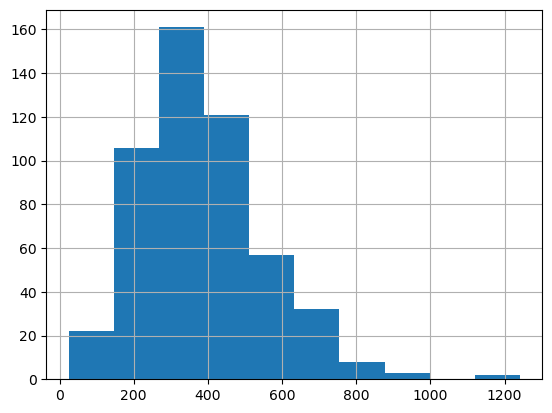

In [23]:
df_control.total_price.hist()

<Axes: >

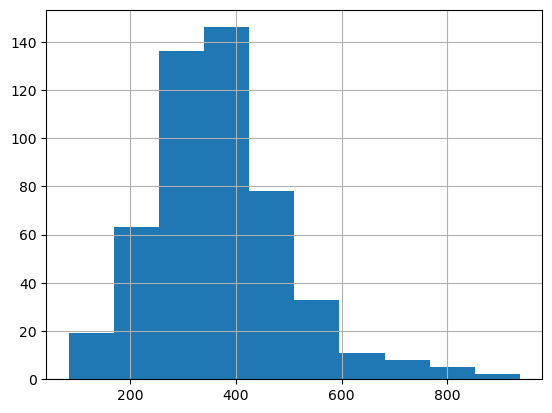

In [24]:
df_test.total_price.hist()

Визуально видно, что обе выборки у нас не распределены нормально, но визуального теста не достаточно.
Данные у нас количественные, более того, они дискретные, а значит необходимо проверить распределение на нормальность, сделать это можно через тест Шапиро-Уилка или через normaltest

In [25]:
for sample in (df_test.total_price, df_control.total_price):
  p_value_norm = shapiro(sample).pvalue
  print(f'p_value = {p_value_norm}')
  print('==============')

  if (p_value_norm < 0.05):
      print("Отвергаем нулевую гипотезу в пользу альтернативной гипотезы, распределение значений не является нормальным.")
  else:
      print("Нулевая гипотеза не отвергается. Данные распределены по нормальному закону.")

p_value = 2.0940003897518267e-10
Отвергаем нулевую гипотезу в пользу альтернативной гипотезы, распределение значений не является нормальным.
p_value = 2.5535374162388713e-11
Отвергаем нулевую гипотезу в пользу альтернативной гипотезы, распределение значений не является нормальным.


In [26]:
#stats.shapiro(df_control.total_price)

In [27]:
#stats.shapiro(df_test.total_price)

In [28]:
pingouin.normality(data=df_mean_price, dv="total_price", 
                   group="group", method="normaltest")

,W,pval,normal
group,,,
0,82.503208,1.215223e-18,False
1,71.621174,2.803236e-16,False


normaltest подтверждает информацию о ненормальности распределений.

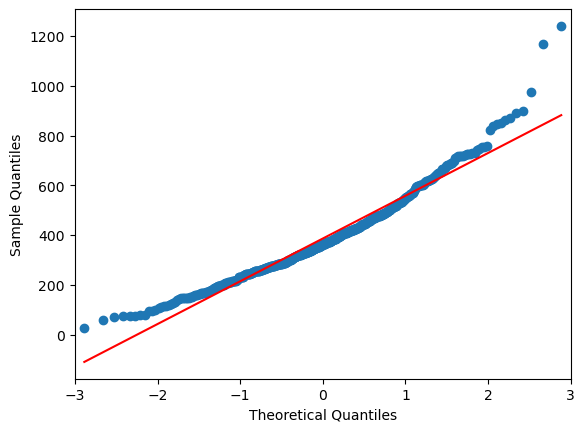

In [29]:
sm.qqplot(df_control.total_price, line='s')
plt.show()

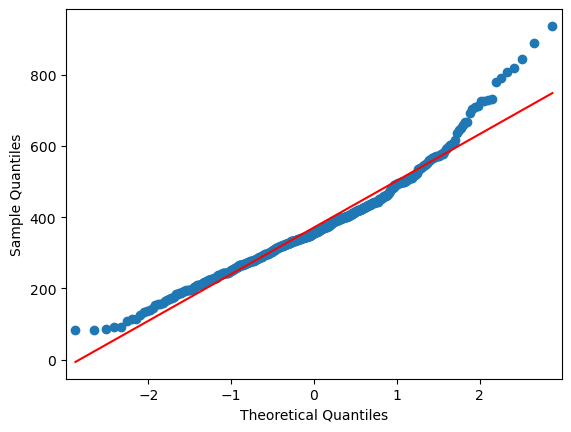

In [30]:
sm.qqplot(df_test.total_price, line='s')
plt.show()

Посмотреть актуальность размера выборок мы не можем, т.к. мы не знаем размер ожидаемого эффекта и поэтому не можем рассчитать MDE.

In [31]:
df_control.total_price.shape[0]

512

In [32]:
df_test.total_price.shape[0]

501

У нас в наличии ненормальное распределение у двух независимых групп дискретных данных, поэтому используем критерий Манна-Уитни.

In [33]:
stats. mannwhitneyu (df_control.total_price, df_test.total_price, alternative='greater')

MannwhitneyuResult(statistic=130986.5, pvalue=0.2788094919425952)

In [79]:
mannwhitneyu_res = mannwhitneyu(df_control.total_price, df_test.total_price, alternative='greater')

print(f'p-value = {round(mannwhitneyu_res.pvalue, 4)}')
print('===========================')

if round(mannwhitneyu_res.pvalue, 4) < 0.05:
    print("Отвергаем нулевую гипотезу в пользу альтернативной гипотезы, имеются статзначимые ризличия в группах.")
else:
    print("Нулевая гипотеза не отвергается и статзначимых различий в группах нет.")

p-value = 0.2788
Нулевая гипотеза не отвергается и статзначимых различий в группах нет.


In [35]:
ttest_ind(df_control.total_price, df_test.total_price, alternative = 'greater')

Ttest_indResult(statistic=1.5407052777251002, pvalue=0.061850724942615336)

In [36]:
alpha = 0.05
results = ttest_ind(
    df_control.total_price, 
    df_test.total_price,
    alternative='greater') #‘greater’: среднее значение распределения, лежащего в основе первой выборки, больше среднего значения распределения, лежащего в основе второй выборки.

print(f'p-value = {round(results.pvalue, 4)}')
print('===========================')

if round(results.pvalue, 4) < alpha:
    print("Отвергаем нулевую гипотезу в пользу альтернативной гипотезы, имеются статзначимые ризличия в группах.")
else:
    print("Нулевая гипотеза не отвергается и статзначимых различий в группах нет.")

p-value = 0.0619
Нулевая гипотеза не отвергается и статзначимых различий в группах нет.


В таком случае попробуем исследовать как изменилось среднее количество товаров в заказе на каждого пользователя и среднее количество заказов на каждого пользователя. Датасет с убранными данными по отмененным заказам у нас есть, воспользуемся им.

In [37]:
users_orders_no_cancel.head(2)

,user_id,order_id,action,date,group,creation_time,product_ids_str,total_price
0,964,1255,create_order,2022-08-26,0,2022-08-26 00:00:19,"[75, 22, 53, 84]",408.7
1,965,1256,create_order,2022-08-26,1,2022-08-26 00:02:21,"[56, 76, 39]",250.5


Сначала посмотрим среднее количество заказов на каждого пользователя в контрольной и тестовой группе.

In [38]:
df_control_orders_count = users_orders_no_cancel.query('group == 0').groupby('user_id').agg({'order_id':'count'})
df_control_orders_count.mean()

order_id    2.982422
dtype: float64

In [39]:
df_test_orders_count = users_orders_no_cancel.query('group == 1').groupby('user_id').agg({'order_id':'count'})
df_test_orders_count.mean()

order_id    4.754491
dtype: float64

Необходимо проверить нормальность распределения выборок.

array([[<Axes: title={'center': 'order_id'}>]], dtype=object)

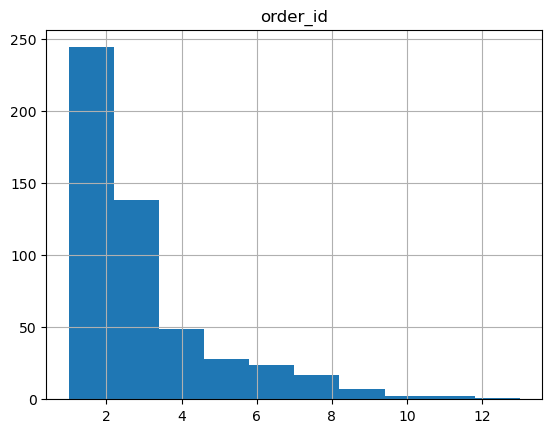

In [40]:
df_control_orders_count.hist()

array([[<Axes: title={'center': 'order_id'}>]], dtype=object)

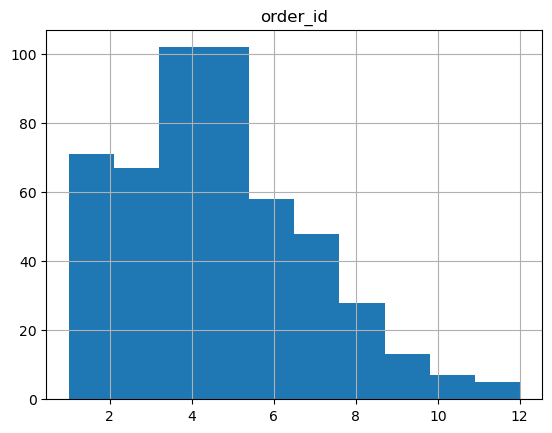

In [41]:
df_test_orders_count.hist()

In [42]:
for sample in (df_test_orders_count, df_control_orders_count):
  p_value_norm = shapiro(sample).pvalue
  print(f'p_value = {p_value_norm}')
  print('==============')

  if (p_value_norm < 0.05):
      print("Отвергаем нулевую гипотезу в пользу альтернативной гипотезы, распределение значений не является нормальным.")
  else:
      print("Нулевая гипотеза не отвергается. Данные распределены по нормальному закону.")

p_value = 7.854406014473625e-10
Отвергаем нулевую гипотезу в пользу альтернативной гипотезы, распределение значений не является нормальным.
p_value = 4.7130800860460576e-23
Отвергаем нулевую гипотезу в пользу альтернативной гипотезы, распределение значений не является нормальным.


In [43]:
pingouin.normality(data=df_test_orders_count, method="normaltest")

,W,pval,normal
order_id,17.210719,0.000183,False


In [44]:
pingouin.normality(data=df_control_orders_count, method="normaltest")

,W,pval,normal
order_id,178.266627,1.949368e-39,False


Распределние у нас не имеет нормального вида в обеих выборках, и данные количественные в двух независимых выборках. Возьмем Критерий Манна Уитни и продублируем критерием Стьюдента.

In [45]:
df_control_orders_count = df_control_orders_count.reset_index(drop= True )

In [46]:
df_test_orders_count = df_test_orders_count.reset_index(drop= True )
df_test_orders_count

,order_id
0,9
1,5
2,2
3,5
4,3
...,...
496,5
497,4
498,6
499,5


In [62]:
c_o_c = round(df_control_orders_count.mean().item(), 2)
t_o_c = round(df_test_orders_count.mean().item(), 2)
print(f'Среднее количество заказов на каждого пользователя в контрольной группе {c_o_c}')
print(f'Среднее количество заказов на каждого пользователя в тестовой группе {t_o_c}')

Среднее количество заказов на каждого пользователя в контрольной группе 2.98
Среднее количество заказов на каждого пользователя в тестовой группе 4.75


In [78]:
mannwhitneyu_res = mannwhitneyu(df_control_orders_count, df_test_orders_count, alternative='less')

print(f'p-value = {mannwhitneyu_res.pvalue}')
print('===========================')

if mannwhitneyu_res.pvalue < 0.05:
    print("Отвергаем нулевую гипотезу в пользу альтернативной гипотезы, имеются статзначимые ризличия в группах.")
else:
    print("Нулевая гипотеза не отвергается и статзначимых различий в группах нет.")

p-value = [6.09987599e-46]
Отвергаем нулевую гипотезу в пользу альтернативной гипотезы, имеются статзначимые ризличия в группах.


In [48]:
alpha = 0.05
results = ttest_ind(
    df_control_orders_count, 
    df_test_orders_count,
    alternative='less') #‘less’: среднее значение распределения, лежащего в основе первой выборки, меньше среднего значения распределения, лежащего в основе второй выборки.

print(f'p-value = {results.pvalue}')
print('===========================')

if results.pvalue < alpha:
    print("Отвергаем нулевую гипотезу в пользу альтернативной гипотезы, имеются статзначимые ризличия в группах.")
else:
    print("Нулевая гипотеза не отвергается и статзначимых различий в группах нет.")

p-value = [4.21538866e-41]
Отвергаем нулевую гипотезу в пользу альтернативной гипотезы, имеются статзначимые ризличия в группах.


In [49]:
c_o_c = round(df_control_orders_count.mean().item(), 2)
t_o_c = round(df_test_orders_count.mean().item(), 2)
if c_o_c < t_o_c:
    print(f"Новая система рекомендаций смогла принести пользу бизнесу и пользователям приложения. \nСтоит включать новую систему рекомендаций на всех пользователей. \nСреднее количество заказов на каждого пользователя в тестовой группе увеличилось и стало {t_o_c} \nв сравнении с контрольной группой, где было {c_o_c}")
else:
    print(f"Новая система рекомендаций не смогла принести пользу бизнесу и пользователям приложения. \nНе стоит включать новую систему рекомендаций на всех пользователей. \nСреднее количество заказов на каждого пользователя в тестовой группе уменьшилось и стало {t_o_c} \nв сравнении с контрольной группой, где было {c_o_c}")

Новая система рекомендаций смогла принести пользу бизнесу и пользователям приложения. 
Стоит включать новую систему рекомендаций на всех пользователей. 
Среднее количество заказов на каждого пользователя в тестовой группе увеличилось и стало 4.75 
в сравнении с контрольной группой, где было 2.98


Нам осталось сравнить среднее количество товаров в каждом чеке.

In [50]:
users_orders_no_cancel_explode = users_orders_no_cancel.explode('product_ids_str').reset_index(drop= True )
users_orders_no_cancel_explode

,user_id,order_id,action,date,group,creation_time,product_ids_str,total_price
0,964,1255,create_order,2022-08-26,0,2022-08-26 00:00:19,75,408.7
1,964,1255,create_order,2022-08-26,0,2022-08-26 00:00:19,22,408.7
2,964,1255,create_order,2022-08-26,0,2022-08-26 00:00:19,53,408.7
3,964,1255,create_order,2022-08-26,0,2022-08-26 00:00:19,84,408.7
4,965,1256,create_order,2022-08-26,1,2022-08-26 00:02:21,56,250.5
...,...,...,...,...,...,...,...,...
13078,1461,59487,create_order,2022-09-08,0,2022-09-08 23:29:06,9,501.9
13079,1461,59487,create_order,2022-09-08,0,2022-09-08 23:29:06,62,501.9
13080,1461,59487,create_order,2022-09-08,0,2022-09-08 23:29:06,77,501.9
13081,1376,59533,create_order,2022-09-08,0,2022-09-08 23:41:24,17,390.3


In [51]:
control_count_products = users_orders_no_cancel_explode.query('group == 0') \
                                                    .groupby('order_id') \
                                                    .agg({'product_ids_str':'count'}) \
                                                    .reset_index(drop= True ) \
                                                    .rename(columns = {'product_ids_str':'count_products'})
control_count_products.head()

,count_products
0,4
1,4
2,4
3,4
4,5


In [52]:
test_count_products = users_orders_no_cancel_explode.query('group == 1') \
                                                    .groupby('order_id') \
                                                    .agg({'product_ids_str':'count'}) \
                                                    .reset_index(drop= True ) \
                                                    .rename(columns = {'product_ids_str':'count_products'})
test_count_products.head()

,count_products
0,3
1,4
2,3
3,4
4,2


array([[<Axes: title={'center': 'count_products'}>]], dtype=object)

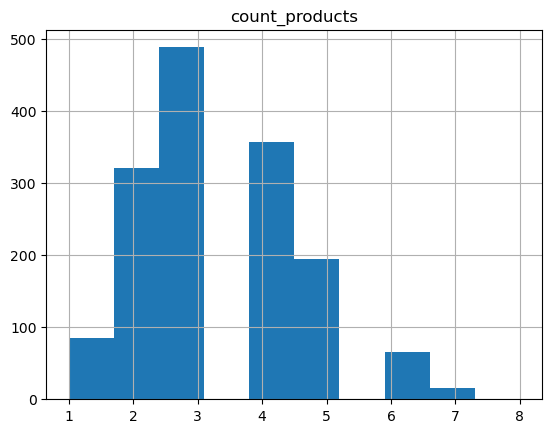

In [53]:
control_count_products.hist()

array([[<Axes: title={'center': 'count_products'}>]], dtype=object)

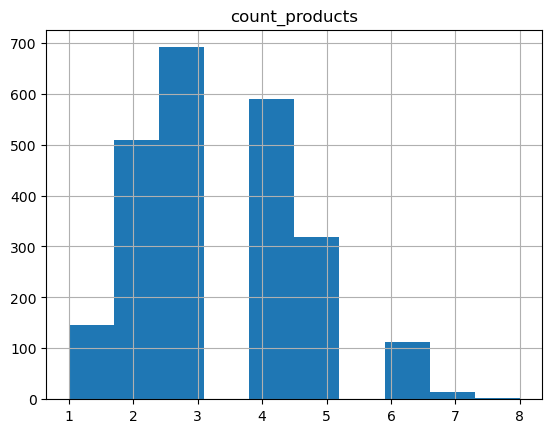

In [54]:
test_count_products.hist()

In [55]:
for sample in (test_count_products, control_count_products):
  p_value_norm = shapiro(sample).pvalue
  print(f'p_value = {p_value_norm}')
  print('==============')

  if (p_value_norm < 0.05):
      print("Отвергаем нулевую гипотезу в пользу альтернативной гипотезы, распределение значений не является нормальным.")
  else:
      print("Нулевая гипотеза не отвергается. Данные распределены по нормальному закону.")

p_value = 4.245708800819739e-30
Отвергаем нулевую гипотезу в пользу альтернативной гипотезы, распределение значений не является нормальным.
p_value = 4.1296417258489795e-25
Отвергаем нулевую гипотезу в пользу альтернативной гипотезы, распределение значений не является нормальным.


In [56]:
pingouin.normality(data=control_count_products, method="normaltest")

,W,pval,normal
count_products,36.287512,1.319067e-08,False


In [57]:
pingouin.normality(data=test_count_products, method="normaltest")

,W,pval,normal
count_products,42.201912,6.854430e-10,False


Распределние у нас не имеет нормального вида в обеих выборках, и данные количественные в двух независимых выборках. Возьмем Критерий Манна Уитни и продублируем критерием Стьюдента.

In [73]:
ccp = round(control_count_products.mean().item(), 2)
tcp = round(test_count_products.mean().item(), 2)
print(f'Среднее количество товаров в каждом заказе в контрольной группе {ccp}')
print(f'Среднее количество товаров в каждом заказе в тестовой группе {tcp}')

Среднее количество товаров в каждом заказе в контрольной группе 3.34
Среднее количество товаров в каждом заказе в тестовой группе 3.35


In [77]:
mannwhitneyu_res = mannwhitneyu(control_count_products, test_count_products, alternative='less')

print(f'p-value = {mannwhitneyu_res.pvalue}')
print('===========================')

if mannwhitneyu_res.pvalue < 0.05:
    print("Отвергаем нулевую гипотезу в пользу альтернативной гипотезы, имеются статзначимые ризличия в группах.")
else:
    print("Нулевая гипотеза не отвергается и статзначимых различий в группах нет.")

p-value = [0.3541639]
Нулевая гипотеза не отвергается и статзначимых различий в группах нет.


In [70]:
alpha = 0.05
results = ttest_ind(
    df_control_orders_count, 
    df_test_orders_count,
    alternative='less') #‘less’: среднее значение распределения, лежащего в основе первой выборки, меньше среднего значения распределения, лежащего в основе второй выборки.

print(f'p-value = {results.pvalue}')
print('===========================')

if results.pvalue < alpha:
    print("Отвергаем нулевую гипотезу в пользу альтернативной гипотезы, имеются статзначимые ризличия в группах.")
else:
    print("Нулевая гипотеза не отвергается и статзначимых различий в группах нет.")

p-value = [4.21538866e-41]
Отвергаем нулевую гипотезу в пользу альтернативной гипотезы, имеются статзначимые ризличия в группах.


При выборе критерия Манна Уитни нужно быть осторожным ибо результаты этого критерия могут

In [67]:
if ccp < tcp:
    print(f"Новая система рекомендаций смогла принести пользу бизнесу и пользователям приложения. \nСтоит включать новую систему рекомендаций на всех пользователей. \nСреднее количество заказов на каждого пользователя в тестовой группе увеличилось и стало {tcp} \nв сравнении с контрольной группой, где было {ccp}")
else:
    print(f"Новая система рекомендаций не смогла принести пользу бизнесу и пользователям приложения. \nНе стоит включать новую систему рекомендаций на всех пользователей. \nСреднее количество заказов на каждого пользователя в тестовой группе уменьшилось и стало {tcp} \nв сравнении с контрольной группой, где было {ccp}")

Новая система рекомендаций смогла принести пользу бизнесу и пользователям приложения. 
Стоит включать новую систему рекомендаций на всех пользователей. 
Среднее количество заказов на каждого пользователя в тестовой группе увеличилось и стало 3.35 
в сравнении с контрольной группой, где было 3.34


На самом деле разница на столько незначительна в сравнении среднего количества товаров в каждом чеке, что можно на эту метрику не опираться.

#### Из трех метрик только одна показала у нас и положительный результат на тестовой группе и статзначимые различия выборок. Это была метрика среднего количества заказов на каждого пользователя.
#### Метрика AOV не показала статзначимых различий, и средний чек в тестовой группе меньше, чем в контрольной.
#### Метрика среднего количества товаров на каждый заказ показала примерно равные результаты.
#### Новая система рекомендаций смогла принести пользу бизнесу и пользователям приложения. Стоит включать новую систему рекомендаций на всех пользователей. Среднее количество заказов на каждого пользователя в тестовой группе увеличилось и стало 4.75, в сравнении с контрольной группой, где было 2.98.